In [2]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from old.harmonization import CombatModel
from old.harmonization import SiteWiseStandardScaler

In [4]:
save_path = 'results/figures/feature_analysis'
os.makedirs(save_path, exist_ok=True)

In [5]:
channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

In [6]:
ELM19_info_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_info_filtered_norm.csv'
ELM19_features_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_features_filtered_norm.csv'

In [7]:
df_info = pd.read_csv(ELM19_info_filtered_norm_path)
df_feats = pd.read_csv(ELM19_features_filtered_norm_path)

In [24]:
scaler = SiteWiseStandardScaler()
df_feats_harmonized = scaler.fit_transform(df_feats, df_info['institution_id'])

In [8]:
combat = CombatModel()

df_feats_harmonized = combat.fit_transform(
    data=df_feats.to_numpy(),
    sites=df_info['institution_id'].to_numpy(),
    discrete_covariates=df_info[['patient_sex']].to_numpy(),   
    continuous_covariates=df_info[['age_dec']].to_numpy()    
)

df_feats_harmonized = pd.DataFrame(
    df_feats_harmonized,
    columns=df_feats.columns,
    index=df_feats.index
)

In [9]:
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    m1, m2 = x1.mean(), x2.mean()
    v1, v2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    denom = (n1 + n2 - 2)
    if denom == 0:
        return 0
    pooled = np.sqrt(((n1 - 1)*v1 + (n2 - 1)*v2) / denom)

    return 0 if pooled == 0 else (m1 - m2) / pooled

df_all = pd.concat([
    df_info.reset_index(drop=True), 
    df_feats_harmonized.reset_index(drop=True)
], axis=1)

# results = {}
# for inst_id, group in df_all.groupby("institution_id"):
#     rest = df_all.loc[df_all['institution_id'] != inst_id, df_feats.columns]
#     d_scores = {feat: cohens_d(group[feat], rest[feat]) for feat in df_feats.columns}
#     results[inst_id] = d_scores

# df_cohens_d = pd.DataFrame(results).T


results_ava = {}

institutions = df_all['institution_id'].unique()
for inst1 in institutions:
    row_scores = {}
    group1 = df_all[df_all['institution_id'] == inst1][df_feats_harmonized.columns]
    for inst2 in institutions:
        group2 = df_all[df_all['institution_id'] == inst2][df_feats_harmonized.columns]
        d_vals = [cohens_d(group1[feat], group2[feat]) for feat in df_feats_harmonized.columns]
        row_scores[inst2] = np.mean(np.abs(d_vals))
    results_ava[inst1] = row_scores

df_cohens_d_ava = pd.DataFrame(results_ava)

In [11]:
df_cohens_d_ava.to_csv('results/tables/feature_analysis/combat_d_cohen.csv',  index=False)

# All vs All

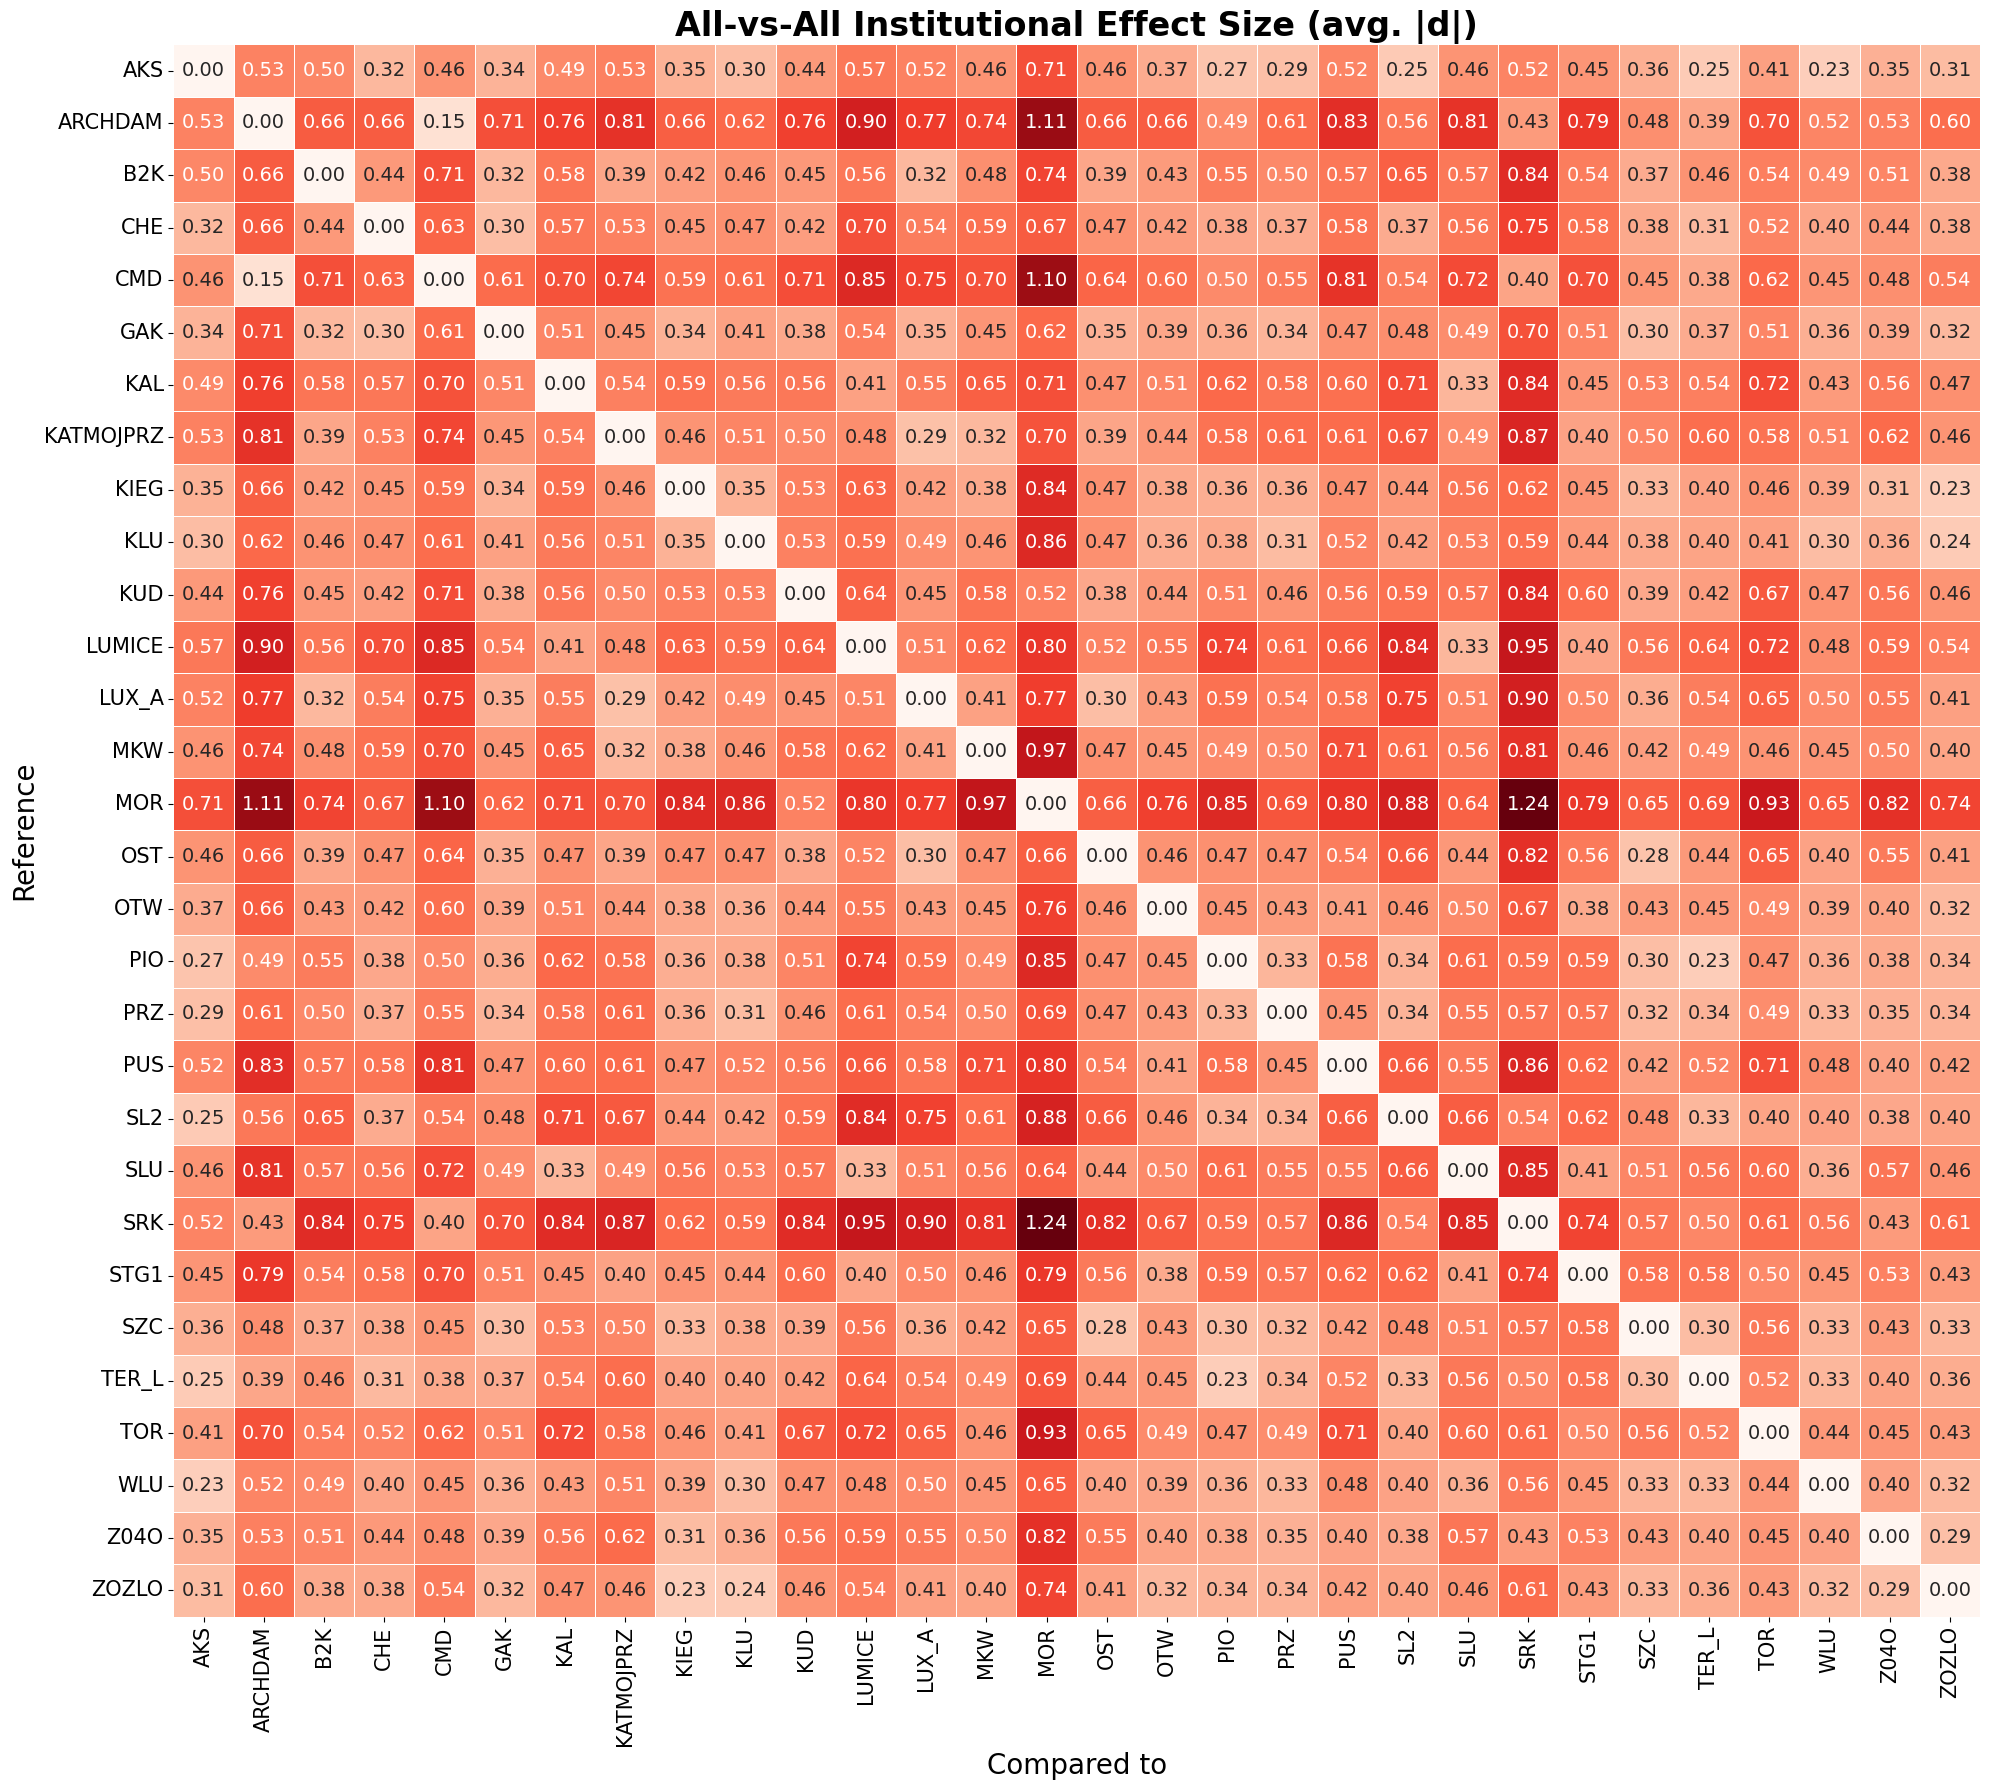

In [14]:
sorted_index = sorted(df_cohens_d_ava.index)
df_cohens_d_ava = df_cohens_d_ava.loc[sorted_index, sorted_index]

plt.figure(figsize=(20, 18))
ax = sns.heatmap(df_cohens_d_ava, 
                 cmap='Reds', 
                 annot=True, 
                 fmt=".2f", 
                 linewidths=0.5,
                 annot_kws={"size": 14},
                 cbar=False
)

ax.set_ylabel("Reference", fontsize=20)
ax.set_xlabel("Compared to", fontsize=20)
ax.set_title("All-vs-All Institutional Effect Size (avg. |d|)", fontsize=24, weight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'cohens_d_heatmap_all_vs_all.png'), dpi=300, bbox_inches='tight')
plt.show()

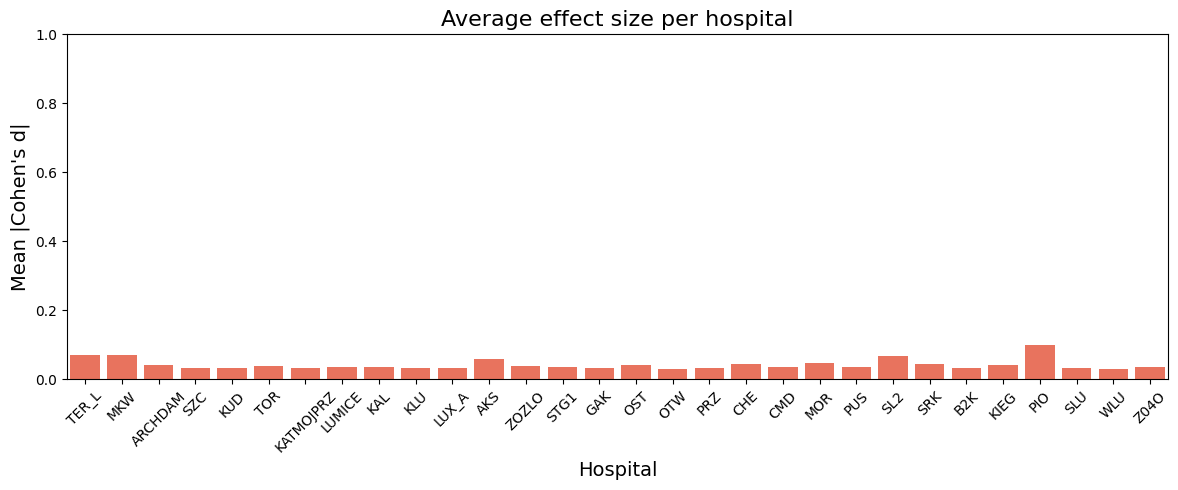

In [12]:
df_no_diag = df_cohens_d_ava.copy()
np.fill_diagonal(df_no_diag.values, np.nan)
row_means_no_diag = df_no_diag.abs().mean(axis=1)

plt.figure(figsize=(12, 5))
sns.barplot(x=row_means_no_diag.index, y=row_means_no_diag.values, color='tomato')
plt.ylabel("Mean |Cohen's d|", fontsize=14)
plt.xlabel("Hospital", fontsize=14)
plt.title("Average effect size per hospital", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0,1)
plt.show()

In [56]:
def row_mean_abs_no_diag(csv_path):
    df = pd.read_csv(csv_path)
    mat = df.values.astype(float)
    np.fill_diagonal(mat, np.nan)
    result = pd.Series(np.nanmean(np.abs(mat), axis=0), index=df.columns)
    return result

unharmonized_cohens_d_mean = row_mean_abs_no_diag('results/tables/feature_analysis/unharmonized_d_cohen.csv')
sorted_index = unharmonized_cohens_d_mean.sort_values(ascending=False).index
unharmonized_cohens_d_mean = unharmonized_cohens_d_mean.loc[sorted_index]

standard_scaler_cohens_d_mean = row_mean_abs_no_diag('results/tables/feature_analysis/standard_scaler_d_cohen.csv')
standard_scaler_cohens_d_mean = standard_scaler_cohens_d_mean.loc[sorted_index]

combat_cohens_d_mean = row_mean_abs_no_diag('results/tables/feature_analysis/combat_d_cohen.csv')
combat_cohens_d_mean = combat_cohens_d_mean.loc[sorted_index]

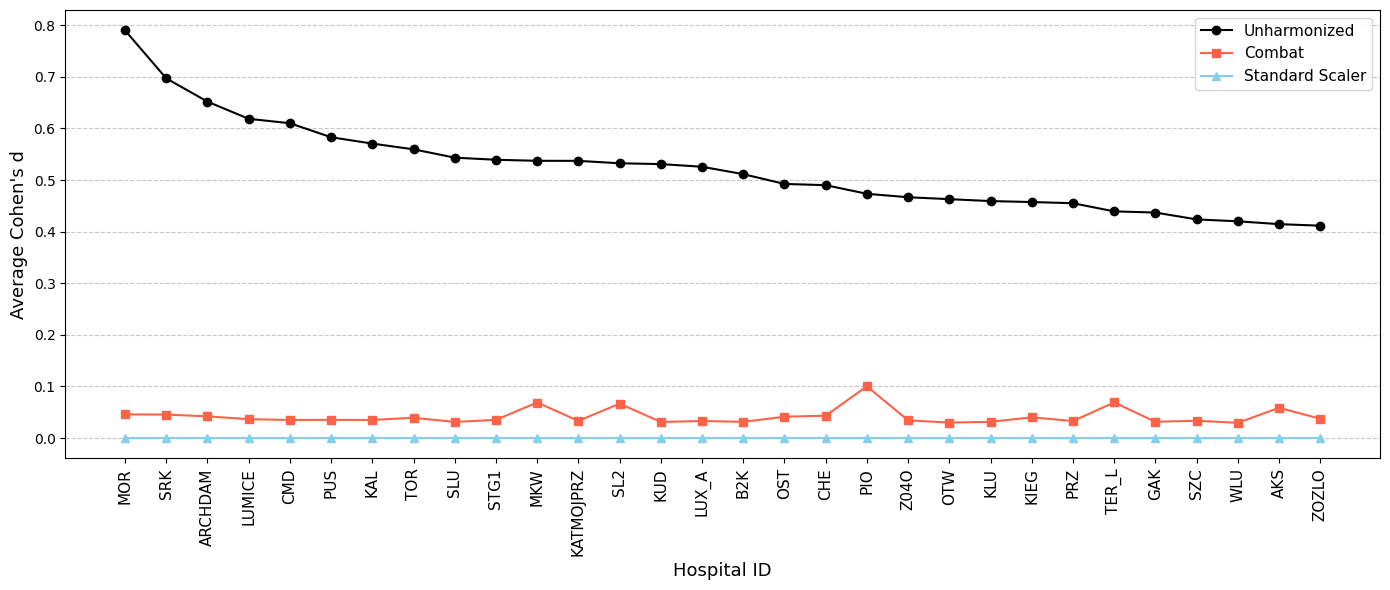

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(unharmonized_cohens_d_mean, marker='o', linestyle='-', color='black', label='Unharmonized')
plt.plot(combat_cohens_d_mean, marker='s', linestyle='-', color='tomato', label='Combat')
plt.plot(standard_scaler_cohens_d_mean, marker='^', linestyle='-', color='skyblue', label='Standard Scaler')

plt.ylabel("Average Cohen's d", fontsize=13)
plt.xlabel("Hospital ID", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=11)
#plt.title("Average MCC per Class Using Different Feature Sets", fontsize=16, weight='bold')
plt.tight_layout()

plt.savefig('results/figures/feature_analysis/cohen_d_harmonization_comparison.png', dpi=300)
plt.show()